
### 코드 설명

1. **CIFAR-100 사전학습:**  
   CIFAR-100 데이터셋을 사용해 `SimpleCNN` 모델을 5 에폭 동안 학습한 후, 가중치를 저장합니다.

2. **MNIST 데이터 전처리:**  
   MNIST 이미지를 32×32, 3채널로 변환하여 CIFAR-100 모델에 맞게 전처리합니다.

3. **MNIST Full Fine-tuning:**  
   - CIFAR-100 사전학습된 feature extractor를 불러온 후, classifier의 마지막 레이어를 `Linear(256, 10)`으로 교체합니다.  
   - 전체 네트워크를 업데이트하며 (전체 파라미터 학습), 작은 학습률(1e-4)을 사용합니다.  
   - 에폭별 train/validation loss와 accuracy를 각각 `ft_train_losses`, `ft_train_accs`, `ft_val_losses`, `ft_val_accs`에 저장합니다.

4. **MNIST Feature Extraction:**  
   - 동일하게 사전학습된 feature extractor를 로드한 후, feature extractor는 고정시키고 classifier만 재정의하여 업데이트합니다.  
   - classifier만 업데이트합니다. 학습률은 1e-3을 사용합니다.  
   - 에폭별 metric은 `fe_train_losses`, `fe_train_accs`, `fe_val_losses`, `fe_val_accs`에 저장합니다.

5. **성능 비교 Plot:**  
   - 두 실험의 Accuracy와 Loss를 각각 plot하여 비교합니다.

이 코드를 실행하면 두 접근법의 에폭별 성능 변화를 비교할 수 있는 plot이 생성됩니다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
# 이미지 시각화를 위한 함수
def imshow(img, title=None, cmap=None):
    npimg = img.numpy()
    if npimg.shape[0] == 1:  # 흑백 이미지만
        npimg = npimg[0]
    else:
        npimg = np.transpose(npimg, (1, 2, 0))  # c, h, w -> h, w, c
    plt.imshow(npimg, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis('off')

In [3]:
def print_dataset_info(name, train_set, test_set):
    sample_img, smple_label = train_set[0]
    print(f'========= {name} =========')
    print("Train 샘플 개수 : ", len(train_set))
    print("Test 샘플 개수 : ", len(test_set))
    print("샘플 이미지 텐서 shape : ", sample_img)
    if hasattr(train_set, 'classes'):
        print("클래스 (카테고리) 개수 :", len(train_set.classes))
        print("클래스 이름 :", train_set.classes)
    print()

In [4]:
def visualize_one_per_category(dataset, dataset_name='Dataset', cmap=None):
    """
    각 카테고리에서 1개의 샘플 이미지를 수집하여 한 화면에 grid로 시각화합니다.
    - dataset: torchvision 데이터셋 (transform이 적용된 상태)
    - dataset_name: 데이터셋 이름 (출력 제목에 사용)
    - cmap: 흑백일 경우 'gray' 지정
    """
    
    samples = {}  # key: label, value: 이미지 텐서
    targets = dataset.targets if hasattr(dataset, 'targets') else dataset.train_labels
    
    for idx in range(len(dataset)):
        img, label = dataset[idx]
        if torch.is_tensor(label):
            label = label.item()
        if label not in samples:
            samples[label] = img
        if len(samples) >= len(dataset.classes):
            break

    n_categories = len(dataset.classes)
    print(f'{dataset_name} 카테고리 개수 : {n_categories}')
    
    # gird 배치를 위해
    cols = 10 if n_categories >= 10 else n_categories
    rows = math.ceil(n_categories / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    # axes가 2차원 배열인 경우 flatten
    if rows * cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
        
    # 클래스 id 오름차순으로 정렬하여 시각화
    for i, label in enumerate(sorted(samples.keys())):
        ax = axes[i]
        img = samples[label]
        npimg = img.numpy()
        
        if npimg.shape[0] == 1:
            npimg = npimg[0]
            ax.imshow(npimg, cmap=cmap)
        else:
            npimg = np.transpose(npimg, (1,2,0))
            ax.imshow(npimg)
        
        class_name = dataset.classes[label] if hasattr(dataset, 'classes') else str(label)
        ax.set_title(class_name, fontsize=8)
    
    # 남은 subplot 축 숨기기
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
        
    plt.suptitle(f'{dataset_name} - 1 sample per category', fontsize=14)
    plt.tight_layout()
    plt.show()

In [5]:
# 데이터셋
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
])

cifar_train = torchvision.datasets.CIFAR100(root='./data', 
                                            train=True, 
                                            download=True, 
                                            transform=transform_cifar)

cifar_test = torchvision.datasets.CIFAR100(root='./data', 
                                            train=False, 
                                            download=True, 
                                            transform=transform_cifar)

In [6]:
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
])

mnist_train = torchvision.datasets.MNIST(root='./data', 
                                         train=True,
                                         download=True, 
                                         transform=transform_mnist)

mnist_test = torchvision.datasets.MNIST(root='./data', 
                                         train=False,
                                         download=True, 
                                         transform=transform_mnist)

In [7]:
# 데이터셋 정보 출력
print_dataset_info('CIFAR100', cifar_train, cifar_test)
print_dataset_info('MNIST', mnist_train, mnist_test)

========= CIFAR100 =========
Train 샘플 개수 :  50000
Test 샘플 개수 :  10000
샘플 이미지 텐서 shape :  tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.7647, 0.8314, 0.7137],
         [1.0000, 0.9961, 0.9961,  ..., 0.6667, 0.6314, 0.5725],
         [1.0000, 0.9961, 1.0000,  ..., 0.7412, 0.6510, 0.4745],
         ...,
         [0.5804, 0.5569, 0.5490,  ..., 0.1176, 0.2549, 0.2980],
         [0.4784, 0.4706, 0.4941,  ..., 0.0863, 0.3804, 0.5529],
         [0.3412, 0.3451, 0.3961,  ..., 0.1333, 0.4118, 0.5412]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.8039, 0.8784, 0.7608],
         [1.0000, 0.9961, 0.9961,  ..., 0.6902, 0.6588, 0.6039],
         [1.0000, 0.9961, 1.0000,  ..., 0.7804, 0.6980, 0.5216],
         ...,
         [0.7255, 0.7137, 0.7020,  ..., 0.0667, 0.2431, 0.3020],
         [0.6157, 0.6078, 0.6275,  ..., 0.0627, 0.4392, 0.6314],
         [0.4784, 0.4784, 0.5255,  ..., 0.1412, 0.5216, 0.6784]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.7569, 0.8000, 0.6549],
         [1.0000, 0.9961, 0.9961, 

CIFAR100 카테고리 개수 : 100


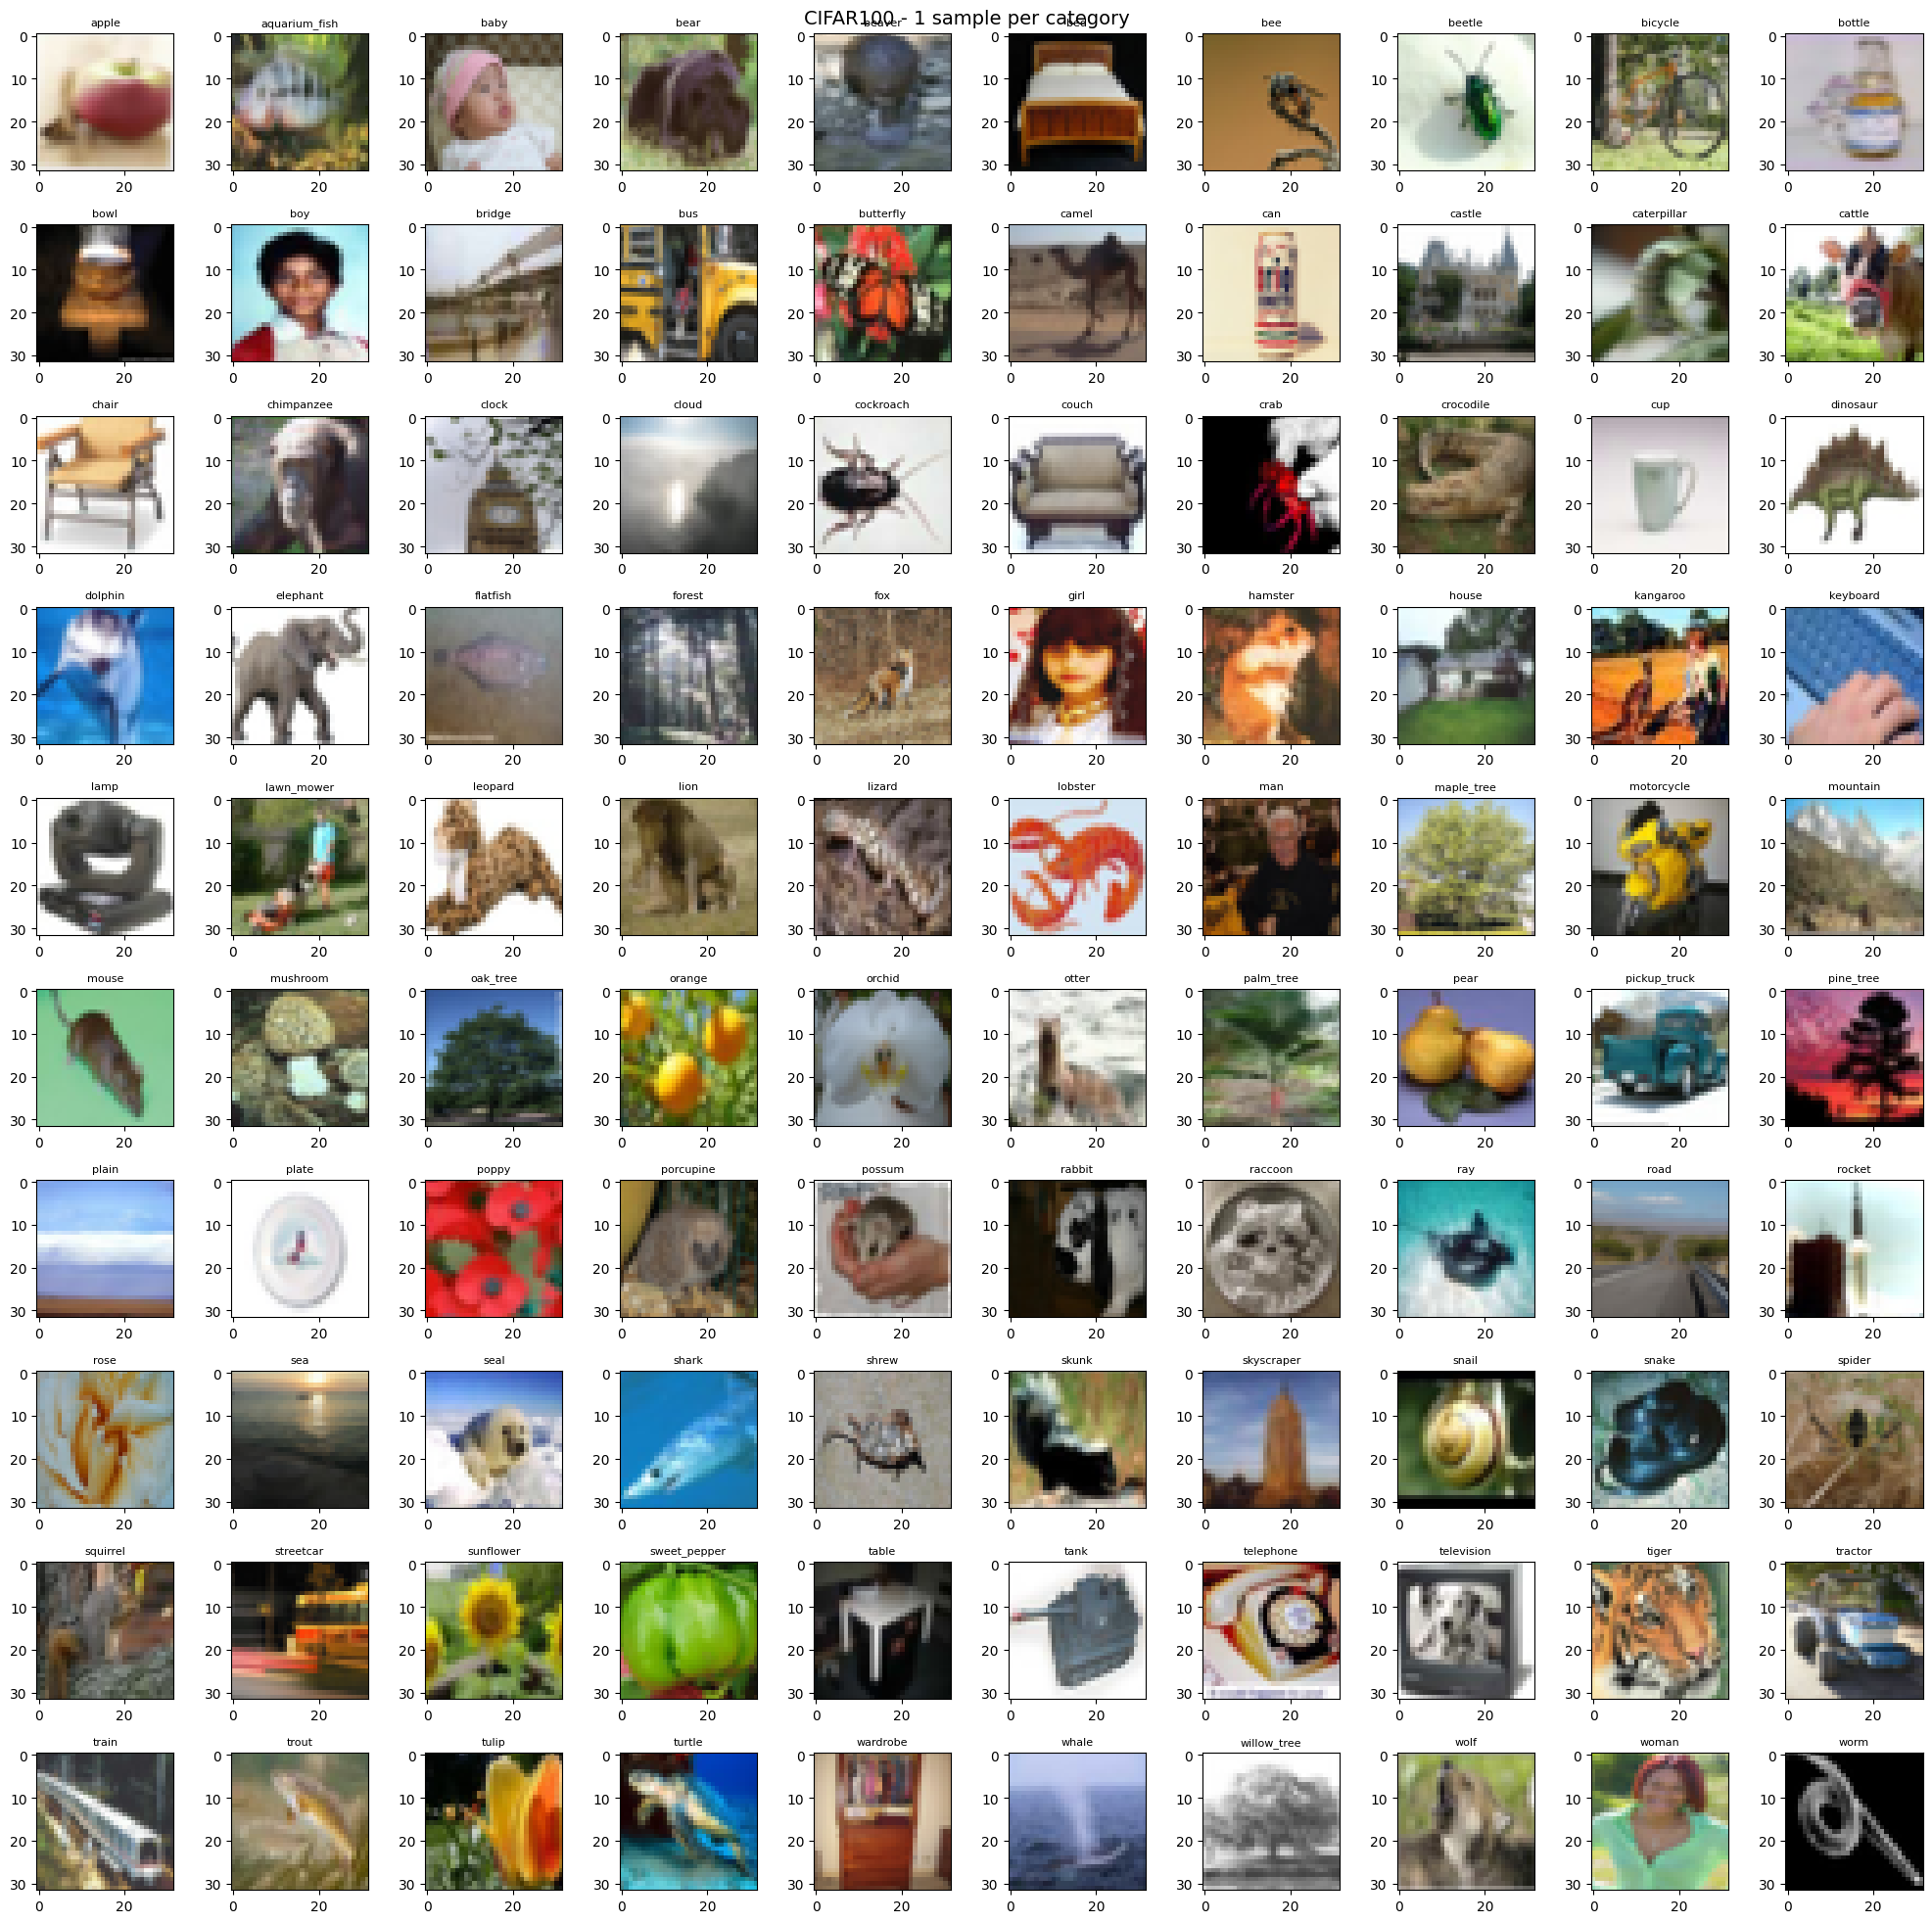

MNIST 카테고리 개수 : 10


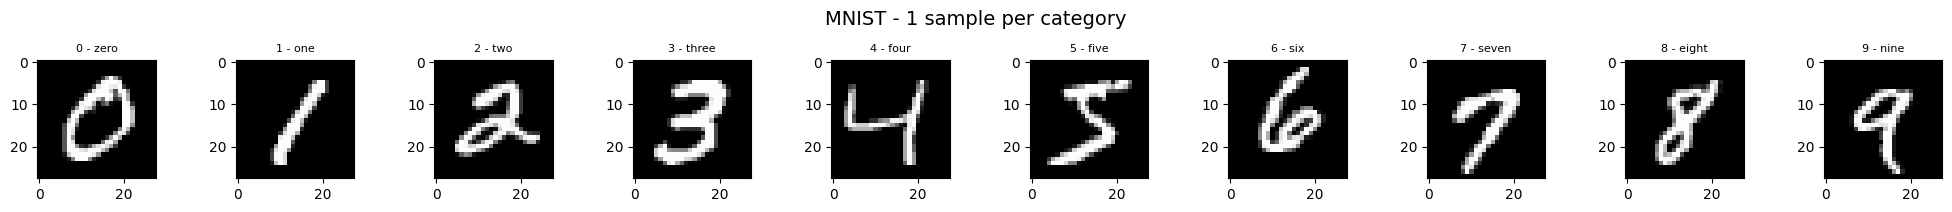

In [8]:
# 카테고리별 이미지
visualize_one_per_category(cifar_train, dataset_name='CIFAR100', cmap=None)
visualize_one_per_category(mnist_train, dataset_name='MNIST', cmap='gray')

### GRAY to RGB

In [9]:
from PIL import Image

# MNIST 데이터셋에서 첫번째 이미지 로드
mnist = mnist_train
gray_img_array = mnist.data[0].numpy()
gray_img_pil = Image.fromarray(gray_img_array, mode='L')  # PIL 이미지 grayscale

# 방법 1: transforms.Grayscale(num_output_channels=3) 사용
transforms_to3 =transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

img_method1 = transforms_to3(gray_img_pil)
print(img_method1.shape)

# 방법 2: PIL convert('RGB')
img_method2 = transforms.ToTensor()(gray_img_pil.convert('RGB'))

print(img_method2.shape)

diff =torch.abs(img_method1 - img_method2)
max_diff = diff.max().item()
mean_diff = diff.mean().item()

print(max_diff)
print(mean_diff)

torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
0.0
0.0


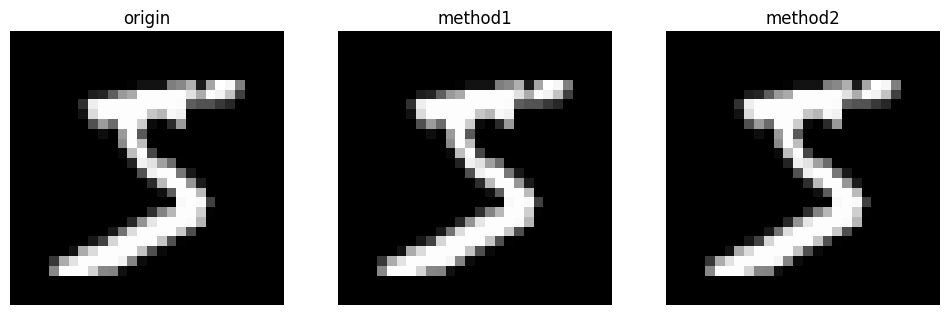

In [10]:
def imshow_tensor(img_tensor, title=None):
    np_img = img_tensor.numpy().transpose(1,2,0)
    plt.imshow(np_img)
    if title:
        plt.title(title)
    plt.axis('off')
    
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(gray_img_pil, cmap='gray')
plt.title('origin')
plt.axis('off')

plt.subplot(1,3,2)
imshow_tensor(img_method1, title='method1')

plt.subplot(1,3,3)
imshow_tensor(img_method2, title='method2')

plt.show()

In [11]:
img_method1[:, 16, 16]

tensor([0.3647, 0.3647, 0.3647])

### 간단한 CNN 모델

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm  # 진행 상황을 표시하기 위한 라이브러리
import os

In [13]:
# device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('사용중인 device :', device)

사용중인 device : cuda


In [ ]:
# 간단한 CNN  모델 정의 (CIFAR-100 입력에 맞춤)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.features = nn.Sequential(   
            # (in, out, kernel, stride, padding)  (b) x c x h x w => 데이터 순서
            nn.Conv2d(3, 32, 3, 1, 1),      # 3 x 32 x 32 -> 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                # 3 x 32 x 32 -> 32 x 16 x 16
            
            nn.Conv2d(32, 64, 3, 1, 1),     # 32 x 16 x 16 -> 64 x 16 x 16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                # 64 x 16 x 16 -> 64 x 8 x 8
            
            nn.Conv2d(64, 128, 3, 1, 1),    # 64 x 8 x 8 -> 128 x 8 x 8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                # 128 x 8 x 8 -> 128 x 4 x 4
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, 100)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

### 학습/검증 함수 정의

In [15]:
# 학습 함수

def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader, leave=False, desc='Train'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total +=  labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc        

In [16]:
a = np.array([1,2,3,4,5])
print(a.mean() * 5)
print(a.sum())

15.0
15


In [17]:
b = torch.rand(8,4)
v, i = torch.max(b, dim=1)
print(b)
print(v)
print(i)

tensor([[0.8361, 0.5959, 0.9118, 0.7697],
        [0.5396, 0.6281, 0.9428, 0.4047],
        [0.6361, 0.0732, 0.1868, 0.8473],
        [0.9761, 0.9486, 0.9983, 0.1920],
        [0.0073, 0.6704, 0.0157, 0.5639],
        [0.9590, 0.2977, 0.0947, 0.4565],
        [0.6161, 0.7574, 0.7398, 0.6780],
        [0.2663, 0.9189, 0.5386, 0.9362]])
tensor([0.9118, 0.9428, 0.8473, 0.9983, 0.6704, 0.9590, 0.7574, 0.9362])
tensor([2, 2, 3, 2, 1, 0, 1, 3])


In [18]:
def validate_epoch(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, leave=False, desc='Val'):
            inputs, labels  = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds==labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        
        return epoch_loss, epoch_acc

### CIFAR-100 사전 학습 (from Scratch)

In [19]:
transform_cifar = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761])
])

cifar_full = torchvision.datasets.CIFAR100(root='./data', 
                                           train=True, 
                                           transform=transform_cifar)

train_size = int(0.9 * len(cifar_full))
val_size = len(cifar_full) - train_size
cifar_train, cifar_val = random_split(cifar_full, [train_size, val_size])

cifar_train_loader = DataLoader(cifar_train, batch_size=128, shuffle=True, num_workers=2)
cifar_val_loader = DataLoader(cifar_val, batch_size=128, shuffle=False, num_workers=2)

In [20]:
model_cifar = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optim_cifar = optim.Adam(model_cifar.parameters(), lr=0.001)

In [21]:
num_epochs = 5
for epoch in range(num_epochs):
    print(f'\nEpoch : {epoch+1}/{num_epochs}')
    
    train_loss, train_acc = train_epoch(model_cifar, cifar_train_loader, criterion, optim_cifar)
    val_loss, val_acc = validate_epoch(model_cifar, cifar_val_loader, criterion)
    
    print(f'Train Loss {train_loss:.4f}  /  ACC {train_acc:.4f}')
    print(f'Val Loss {val_loss:.4f}  /  ACC {val_acc:.4f}')


Epoch : 1/5


Train Loss 3.9813  /  ACC 0.0858
Val Loss 3.3954  /  ACC 0.1894

Epoch : 2/5


Train Loss 3.4174  /  ACC 0.1643
Val Loss 2.9505  /  ACC 0.2680

Epoch : 3/5


Train Loss 3.1552  /  ACC 0.2111
Val Loss 2.6885  /  ACC 0.3264

Epoch : 4/5


Train Loss 3.0006  /  ACC 0.2383
Val Loss 2.6100  /  ACC 0.3318

Epoch : 5/5


Train Loss 2.8918  /  ACC 0.2583
Val Loss 2.5326  /  ACC 0.3480


In [22]:
os.makedirs('./models', exist_ok=True)
torch.save(model_cifar.state_dict(), './models/model_cifar100.pth')

In [23]:
model_cifar.classifier[3]

Linear(in_features=256, out_features=100, bias=True)

In [24]:
model_cifar.features

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

### MNIST Data

In [66]:
transform_mnist = transforms.Compose([
    transforms.Resize(32),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

mnist_full  = torchvision.datasets.MNIST(root='./data', train=True,
                                         transform=transform_mnist, 
                                         download=True)
mnist_train_size = int(0.9 * len(mnist_full))
mnist_val_size = len(mnist_full) - mnist_train_size
mnist_train, mnist_val = random_split(mnist_full, [mnist_train_size, mnist_val_size])

mnist_train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=2)
mnist_val_loader = DataLoader(mnist_val, batch_size=128, shuffle=False, num_workers=2)


In [67]:
a = next(iter(mnist_train_loader))
a[0].size()

torch.Size([128, 3, 32, 32])

### MNIST Full Fine-Tuning

In [68]:
model_mnist_ft = SimpleCNN().to(device)

# 사전학습된 Feature extractor 로드
model_cifar_dict = torch.load('./models/model_cifar100.pth', map_location=device)
model_dict = model_mnist_ft.state_dict()
pretrained_dict = {k: v for k, v in model_cifar_dict.items() if k.startswith("features")}

model_dict.update(pretrained_dict)
model_mnist_ft.load_state_dict(model_dict)

#classifier 교체 : 마지막 레이어를 MNIST 클래스 수에 맞게
model_mnist_ft.classifier[3] = nn.Linear(256, 10).to(device)
print(model_mnist_ft)

optim_mnist_ft = optim.Adam(model_mnist_ft.parameters(), lr=1e-4)

ft_train_losses, ft_train_accs = [],[]
ft_val_losses, ft_val_accs = [],[]

num_epochs_mnist = 3
for epoch in range(num_epochs_mnist):
    print(f"\nMNIST Full Fine-tuning {epoch+1}/{num_epochs_mnist}")
    train_loss, train_acc = train_epoch(model_mnist_ft, mnist_train_loader, criterion, optim_mnist_ft)
    val_loss, val_acc = validate_epoch(model_mnist_ft, mnist_val_loader, criterion)
    print(f"Train Loss: {train_loss:.4f}, Acc {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Acc {val_acc:.4f}")
    ft_train_losses.append(train_loss)
    ft_train_accs.append(train_acc)
    ft_val_losses.append(val_loss)
    ft_val_accs.append(val_acc)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in

Train Loss: 0.3536, Acc 0.9157
Val Loss: 0.0707, Acc 0.9823

MNIST Full Fine-tuning 2/3


Train Loss: 0.0793, Acc 0.9773
Val Loss: 0.0439, Acc 0.9868

MNIST Full Fine-tuning 3/3


Train Loss: 0.0562, Acc 0.9838
Val Loss: 0.0346, Acc 0.9893


### MNIST Feature Extraction (classifier만 업데이트)

In [69]:
model_mnist_fe = SimpleCNN().to(device)
model_dict_fe = model_mnist_fe.state_dict()

pretrained_dict_fe = {k:v for k, v in model_cifar_dict.items() if k.startswith('features')}

model_dict_fe.update(pretrained_dict_fe)
model_mnist_fe.load_state_dict(model_dict_fe)

# feature extractor 고정
for param in model_mnist_fe.features.parameters():
    param.requires_grad = False

# classifier 교체 : 새 분류기로 정의
model_mnist_fe.classifier = nn.Sequential(
    nn.Linear(128*4*4, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)

print(model_mnist_fe)

optim_mnist_fe = optim.Adam(model_mnist_fe.classifier.parameters(), lr=1e-3)

fe_train_losses, fe_train_accs = [],[]
fe_val_losses, fe_val_accs = [], []

for epoch in range(num_epochs_mnist):
    print(f"\n {epoch+1}/{num_epochs_mnist}")
    train_loss, train_acc = train_epoch(model_mnist_fe, mnist_train_loader, criterion, optim_mnist_fe)
    val_loss, val_acc = validate_epoch(model_mnist_fe, mnist_val_loader, criterion)
    print(f"Train loss {train_loss:.4f}, Acc {train_acc:.4f}")
    print(f"Val loss {val_loss:.4f}, Acc {val_acc:.4f}")
    fe_train_losses.append(train_loss)
    fe_train_accs.append(train_acc)
    fe_val_losses.append(val_loss)
    fe_val_accs.append(val_acc)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=Tr

Train:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.1470, Acc 0.9587
Val loss 0.0556, Acc 0.9825

 2/3


Train loss 0.0525, Acc 0.9836
Val loss 0.0498, Acc 0.9853

 3/3


Train loss 0.0420, Acc 0.9868
Val loss 0.0407, Acc 0.9877


In [70]:
model_mnist_fe.features

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [71]:
model_mnist_fe.classifier

Sequential(
  (0): Linear(in_features=2048, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

In [72]:
for name, param in model_mnist_fe.named_parameters():
    print(f"{name} : {param.requires_grad}")

features.0.weight : False
features.0.bias : False
features.1.weight : False
features.1.bias : False
features.4.weight : False
features.4.bias : False
features.5.weight : False
features.5.bias : False
features.8.weight : False
features.8.bias : False
features.9.weight : False
features.9.bias : False
classifier.0.weight : True
classifier.0.bias : True
classifier.2.weight : True
classifier.2.bias : True


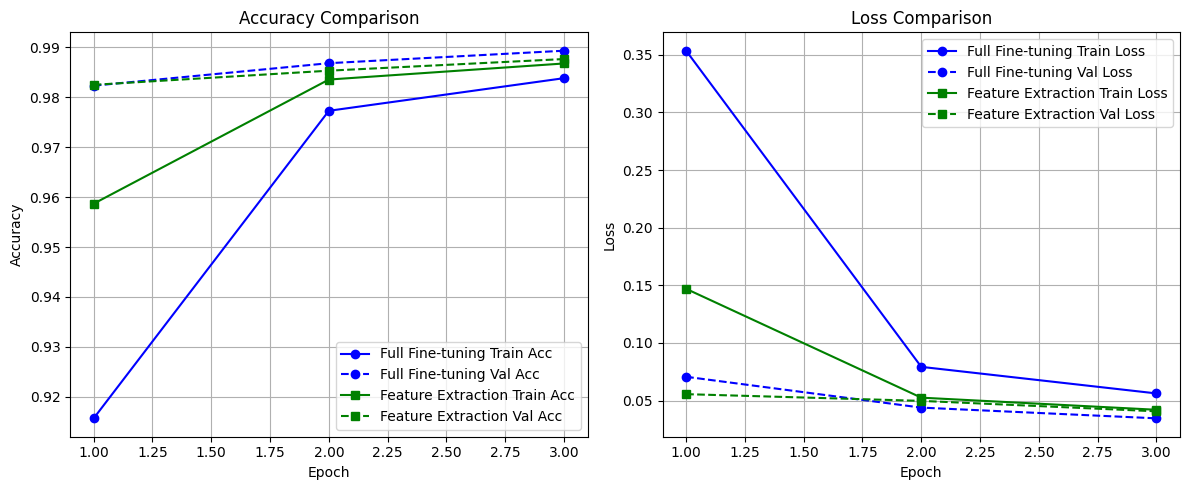

In [73]:
# --------------------------------------------------
# 성능 비교 Plot 그리기 (Accuracy 및 Loss)
# --------------------------------------------------
epochs = range(1, num_epochs_mnist + 1)

plt.figure(figsize=(12, 5))

# Accuracy 비교
plt.subplot(1, 2, 1)
plt.plot(epochs, ft_train_accs, 'o-', c='b', label='Full Fine-tuning Train Acc')
plt.plot(epochs, ft_val_accs, 'o--',c='b', label='Full Fine-tuning Val Acc')
plt.plot(epochs, fe_train_accs, 's-',c='g', label='Feature Extraction Train Acc')
plt.plot(epochs, fe_val_accs, 's--', c='g',label='Feature Extraction Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.grid(True)

# Loss 비교
plt.subplot(1, 2, 2)
plt.plot(epochs, ft_train_losses, 'o-', c='b', label='Full Fine-tuning Train Loss')
plt.plot(epochs, ft_val_losses, 'o--', c='b', label='Full Fine-tuning Val Loss')
plt.plot(epochs, fe_train_losses, 's-',c='g', label='Feature Extraction Train Loss')
plt.plot(epochs, fe_val_losses, 's--', c='g', label='Feature Extraction Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [74]:
pretrained_dict_fe.keys()

dict_keys(['features.0.weight', 'features.0.bias', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.4.weight', 'features.4.bias', 'features.5.weight', 'features.5.bias', 'features.5.running_mean', 'features.5.running_var', 'features.5.num_batches_tracked', 'features.8.weight', 'features.8.bias', 'features.9.weight', 'features.9.bias', 'features.9.running_mean', 'features.9.running_var', 'features.9.num_batches_tracked'])